# Présentation générale de notebook

Il s'agit d'un notebook de script d'expérimentations des différents modèles avec mlflow.

on procède plusieurs étapes :
1) courte analyse exploratoire des données afin de vérifier qu'elles correspondent bien aux besoins
2) pré traitement des données (très couteux en temps, les prétraitements sont enregistrés dans des fichiers afin d'économiser le temps de pré-traitements à faire)
3) préparations des données afin qu'elles soient exploitables par les différents modèles
4) Entraînements et tracking des modèles avec mlflow

# 1 - Importation

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pathlib import Path
from typing import Dict
import numpy as np


# Pour les extractions de features textuelles
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Charger le modèle spaCy pour l'anglais
nlp = spacy.load('en_core_web_sm')

# MFLow
import mlflow

# pour les entraînements des modèles et scoring
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score

# Les modèles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from gensim.models import Word2Vec

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from gensim.models import FastText
from transformers import BertTokenizer, BertForSequenceClassification
import tensorflow as tf

from transformers import TrainingArguments, Trainer

from datasets import Dataset
from accelerate import Accelerator


# 2 - Paramétrages

In [2]:
os.environ["OMP_NUM_THREADS"] = "12"  # Nombre de threads pour le CPU
mlflow.autolog(disable=True)
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Sentiment_classification_v9")

<Experiment: artifact_location='mlflow-artifacts:/778457007112658367', creation_time=1729533984650, experiment_id='778457007112658367', last_update_time=1729533984650, lifecycle_stage='active', name='Sentiment_classification_v9', tags={}>

# 3 - Fonctions

## 3-1 - fonction générique

In [3]:
def perc_fill_rate(datas: pd.DataFrame)-> float:
    """Calculer le taux de remplissage
    
    Parameters:
    datas: Dataframe dont le taux de remplissage est à calculer

    Returns:
    float: taux de remplissage calculé
    """

    return 100 - datas.isna().sum() / len(datas) * 100

def make_title(texte:str):
    """Ecrit tout simplement un ###### texte #####
    Cette fonction a été crée pour éviter de répéter les mêmes écritures de print

    Parameters:
    texte -- Texte à afficher
    """

    print("\n###### " + texte + " ######\n")

def make_plot_dtypes(datas:pd.DataFrame):
    """Crée un camembert de répartition de types utilisés de la dataframe
    
    Parameters:
    datas: Dataframe dont on veut calculer la répartition des types utilisées
    """

    print(datas.dtypes.value_counts())
    plt.figure(figsize=(10,5))
    plt.pie(datas.dtypes.value_counts().values,autopct="%1.2f%%",labels=[str(types) for types in datas.dtypes.value_counts().index])
    plt.title("Répartition des types dans le jeu de données.")
    plt.ylabel("Type des données")
    plt.legend()
    plt.show()

def make_perc_missing_values_info(datas:pd.DataFrame, perc_missing_values_threshold: int = 50) -> sns.barplot:
    """Fonction qui affiche un diagramme en barres contenant le taux de remplissage pour chaque variable de la dataframe
    
    Parameters:
    datas: Dataframe dont on désire afficher le taux de remplissage sous forme d'un diagramme en barres
    perc_missing_values_threshold: Le seuil du pourcentage qui indique si une variable est exploitable ou non (par défaut : 50)
    
    Returns:
    sns.barplot: contient l'objet de barplot
    """

    # Calcul du taux de remplissage
    perc_fill_rate_datas = perc_fill_rate(datas)
    perc_fill_rate_datas = perc_fill_rate_datas.sort_values(ascending=False)

    # Définition de la palette de couleurs en fonction du taux de remplissage
    palette = ["red" if p < perc_missing_values_threshold else "orange" if p < 100 else "green" for p in perc_fill_rate_datas.values]

    display(perc_fill_rate_datas.index)
    display(perc_fill_rate_datas.values)

    # Création d'un grpahique à barres pour le taux de remplissage
    plt.figure(figsize=(25,5))
    sns.barplot(x=perc_fill_rate_datas.index, y=perc_fill_rate_datas.values, hue=perc_fill_rate_datas.index, palette=palette)
    plt.ylabel("Taux de remplissage")
    plt.xlabel("Variables")
    plt.xticks(rotation=90)
    plt.title("Taux de remplissage du fichier")

    # Mise en place d'une ligne rouge marquant le seuil décidé %
    line_seuil = plt.axhline(y=perc_missing_values_threshold, color="red", linestyle="--", label="seuil " + str(perc_missing_values_threshold) + "%")

    # Création et paramétrage des légendes à afficher
    red_patch = mpatches.Patch(color="red", label="< " + str(perc_missing_values_threshold) + "%")
    orange_patch = mpatches.Patch(color="orange", label= "" + str(perc_missing_values_threshold) + "-]100%")
    green_patch = mpatches.Patch(color='green', label='100%')
    plt.legend(handles=[line_seuil, red_patch, orange_patch, green_patch], title='Taux de remplissage', loc='upper right')
    plt.show()

    # Afficher une dataframe sur le taux de remplissage des variables
    var_with_missing_values = perc_fill_rate_datas.loc[perc_fill_rate_datas < 100].to_frame()
    var_with_missing_values = var_with_missing_values.reset_index()
    var_with_missing_values = var_with_missing_values.rename(columns={"index": "Variable", 0: "% Taux remplissage"})
    display(var_with_missing_values)

def analyse_outlier(df: pd.DataFrame):
    """Analyse affiche un boxplot de chaque variable numérique afin d'analyser les outliers
    
    Parameters:
    df: la dataframe dont on veut analyser les outliers
    """

    # Ne sélectionner que les variables numériques
    quantitatives = df.select_dtypes(include=["number"])

    make_title("Statistiques descriptives")
    display(quantitatives.describe())

    # Afficher les boxplots de chaque variable
    nb_var = len(quantitatives.columns)
    nb_cols = 5
    nb_rows = int(nb_var/nb_cols) + 1
    fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(25, nb_rows * 5))
    for i, var in enumerate(quantitatives.columns):
        if nb_rows > 1:
            ax = axes[i // nb_cols, i % nb_cols]
        else:
            ax = axes[i % nb_cols]
        sns.boxplot(x=quantitatives[var], ax=ax)

    # Supprime les emplacements non utilisés
    for i in range(nb_var, nb_rows * nb_cols):
        fig.delaxes(axes.flatten()[i])

    make_title("Boxplots des variables")
    plt.show()
    
def analyse_exploratoire_generique(datas: pd.DataFrame, perc_missing_values_threshold: int = 50, nb_index: int = 1):
    """Effectue une analyse exploratoire générique

    Parameters:
    datas: la dataframe sur laquelle on veut effectuer une analyse exploratoire générique
    perc_missing_values_threshold: Le seuil du pourcentage de valeur manquant qui indique si une variable est exploitable ou non (par défaut: 50)
    nb_index: index de début d'analyse de doublons, utilisé pour analyser les doublons en dehors des index
    """

    # Présenter les informations générales
    make_title("Informations générales")
    datas.info()

    # Afficher la répartition des types dans le jeu de données
    make_title("Répartition des types dans le dataset")
    make_plot_dtypes(datas)


    # Afficher les 5 premières et derniè_res lignes du DataFrame
    make_title("Les 5 premières et dernières lignes")
    head = datas.head()
    tail = datas.tail()
    display(head, tail)

    # Afficher le nombre de valeurs uniques
    make_title("Nombre de valeurs uniques")
    display(datas.nunique().to_frame().T)

    # Afficher le nombre des doublons génériques
    make_title("Doublons génériques (toutes les variables sont utilisées)")
    display(datas.duplicated().sum())

    # Afficher le nombre des doublons sans l'index
    make_title("Doublons sans l'index")
    display(datas[datas.columns[nb_index:]].duplicated().sum())

    # Afficher les informations sur le taux de remplissage 
    make_title("Informations du taux de remplissage")
    make_perc_missing_values_info(datas, perc_missing_values_threshold)

    # Afficher les analyses des variables numériques 
    analyse_outlier(datas)




## 3-2 - Fonctions prétraitement de texte

In [4]:
def preprocess_text(text:str, norm:str = "lemming")->str:
    """Prétraiter un texte avec les traitements suivants :
    - convertir toutes les lettres en miniscules
    - Suppression des poncutations et des caractères spéciaux
    - Tokenization
    - Suppression des mots vides
    - Lemmatisation
    - Suppression des mots inférieur à 3 lettres

    Parameters:
    text: Le texte à prétraiter
    norm: "lemming" ou "stemming" : choix de la normalisation de texte 

    Return:
    Le texte pré-traité
    """

    # Conversion en minuscules
    text = text.lower()
    
    # Suppression des ponctuations et des caractères spéciaux
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Suppression des mots vides
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Normalisation avec lemmatization ou stemming
    if norm == "lemming" :
        doc = nlp(' '.join(tokens))
        tokens = [token.lemma_ for token in doc]
    elif norm == "stemming":
        stemmer = SnowballStemmer("english")
        tokens = [stemmer.stem(token) for token in tokens]     
    else:
        print("la normalisation sélectionné n'est pas prise en charge")

    # Suppression des mots courts
    tokens = [word for word in tokens if len(word) > 3]

    # Remise en forme
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

## 3-3 Training and tracking models

In [5]:
def compute_metrics(pred):
    """
    Calculer l'accuracy pour le Trainer

    pred: les prédictions produits par Trainer
    """

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc}

In [6]:
def track_model_training(model:object, datas:Dict, params:Dict, model_type:str, run_name:str, vectorizer=None):
    """ 
    Exécute l'entraînement des modèles avec GridSearchCv et enregistre les résultats, le meilleur modèle est stocké, les résultats sont stockés dans un serveur mlflow
    Il est nécessaire que mlflow soit lancé et configuré

    Variables:
    model: le modèle choisi

    datas: le dataset text et target

    model_type: le type de modèle afin que la fonction puisse utiliser les démarches adéquante
        type de modèle pris en charge 
            => sklearn

    params: Dictionnaire de paramètres à utiliser pour GridSearchCv

    run_name: nom du run de mlflow

    vectorizer: le vectorizer entraîné
        si type modèle est de sklearn, deux vectorizer pris en charge :
            => SimpleCount pour un bag of words de simpleCount
            => TDIDF pour un bag of words de TDIDF
    """

    # Vérifier si le run n'existe pas, sinon, on ne refait pas les entraînements
    existing_runs = mlflow.search_runs(filter_string=f'tag.mlflow.runName="{run_name}"')
    if len(existing_runs) == 0:

        # Si le modèle est de type sklearn
        if model_type == "sklearn":

                # Préparer l'entrainement cross validation
                cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                scoring = {"accuracy": "accuracy", "roc_auc": "roc_auc"}

                # Démarrer l'entraînement et stocker les résultats dans results
                grid_search = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring=scoring, refit="accuracy", n_jobs=5, return_train_score=False)
                grid_search.fit(datas["X_train"], datas["y_train"])
                results = grid_search.cv_results_
                    
                # Démarrer le tracking et enregistrement du meilleur modèle
                with mlflow.start_run(run_name=run_name):
                    for idx, params in enumerate(results["params"]):
                        with mlflow.start_run(nested=True):

                            # tagger le nom de run
                            mlflow.set_tag("run_name", run_name)
                            
                            # Stocker le nom du modèle et ses paramètres
                            mlflow.log_param("model", type(model).__name__)
                            mlflow.log_params(params)

                            # Stocker les métriques
                            mlflow.log_metric("mean_fit_time", results["mean_fit_time"][idx])
                            mlflow.log_metric("mean_score_time", results["mean_score_time"][idx])
                            mlflow.log_metric("mean_test_accuracy", results["mean_test_accuracy"][idx])
                            mlflow.log_metric("mean_test_roc_auc", results["mean_test_roc_auc"][idx])

                            # Récupérer le meilleur modèle
                            if idx == grid_search.best_index_:

                                # Stocker le meilleur modèle ainsi que le vectorizer associé
                                mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
                                if vectorizer:
                                    mlflow.sklearn.log_model(vectorizer, "vectorizer")

                                # Etablir et enregistrer la courbe ROC-AUC
                                y_pred_proba = grid_search.best_estimator_.predict_proba(datas["X_train"])[:, 1]
                                fpr, tpr, _ = roc_curve(datas["y_train"], y_pred_proba)
                                roc_auc = auc(fpr, tpr)
                                plt.figure()
                                plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
                                plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
                                plt.xlabel("Taux faux positif")
                                plt.ylabel("Taux vrai positif")
                                plt.title("ROC")
                                plt.legend(loc="lower right")
                                mlflow.log_figure(plt.gcf(), "roc_curve.png")
                                plt.close()

        elif model_type == "fine_tuning_bert":
            
            model_to_use = BertForSequenceClassification.from_pretrained(params["model_name"], num_labels=2, ignore_mismatched_sizes=True)
            tokenizer = BertTokenizer.from_pretrained(params["model_name"])

            # Stocker les résultats
            results = []

            # Configurer la validation croisée
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

            # Variables pour suivre le meilleur modèle
            best_mean_accuracy = 0
            best_hyperparams = {}

            # Boucle sur les combinaisons d'hyperparamètres
            for lr in params["learning_rates"]:
                for bs in params["batch_sizes"]:
                    fold_accuracies = []

                    # Boucle pour chaque split de la validation croisée
                    X_train = datas["X_train"]
                    for train_index, val_index in skf.split(X_train, datas["y_train"]):
                        # Créer les jeux de données pour cette fold
                        train_encoding = tokenizer(X_train.iloc[train_index].tolist(), padding="max_length", truncation=True, max_length=250)
                        val_encoding = tokenizer(X_train.iloc[val_index].tolist(), padding="max_length", truncation=True, max_length=250)

                        train_dataset = Dataset.from_dict({
                            "input_ids": train_encoding["input_ids"],
                            "attention_mask": train_encoding["attention_mask"],
                            "labels": datas["y_train"].iloc[train_index]
                        })

                        val_dataset = Dataset.from_dict({
                            "input_ids": val_encoding["input_ids"],
                            "attention_mask": val_encoding["attention_mask"],
                            "labels": datas["y_train"].iloc[val_index]
                        })

                        # Arguments d'entraînement
                        training_args = TrainingArguments(
                            output_dir="./results",
                            eval_strategy="epoch",
                            learning_rate=lr,
                            per_device_train_batch_size=bs,
                            per_device_eval_batch_size=bs,
                            num_train_epochs=params["num_epochs"],
                            weight_decay=0.01,
                            fp16=True,
                            logging_steps=10,
                            report_to="none"
                        )

                        # Créer le Trainer
                        trainer = Trainer(
                            model=model_to_use,
                            args=training_args,
                            train_dataset=train_dataset,
                            eval_dataset=val_dataset,
                            compute_metrics=compute_metrics,
                        )

                        # Entraîner le modèle
                        trainer.train()

                        # Évaluer le modèle
                        eval_results = trainer.evaluate()
                        accuracy = eval_results['eval_accuracy']
                        fold_accuracies.append(accuracy)

                    # Calculer l'accuracy moyenne pour cette combinaison d'hyperparamètres
                    mean_accuracy = np.mean(fold_accuracies)

                    # Stocker les résultats
                    results.append((lr, bs, mean_accuracy))

                    # Vérifier si c'est le meilleur modèle
                    if mean_accuracy > best_mean_accuracy:
                        best_mean_accuracy = mean_accuracy
                        best_hyperparams = {
                            "learning_rate": lr,
                            "batch_size": bs,
                            "num_epochs": params["num_epochs"],
                        }

            # Enregistrer tous les résultats et le meilleur modèle dans MLflow
            with mlflow.start_run(run_name=run_name):
                    for lr, bs, mean_accuracy in results:
                        with mlflow.start_run(nested=True):
                            mlflow.log_param("learning_rate", lr)
                            mlflow.log_param("batch_size", bs)
                            mlflow.log_param("num_epochs", params["num_epochs"])
                            mlflow.log_metric("mean_test_accuracy", mean_accuracy)

                    # Enregistrer le meilleur modèle
                    mlflow.log_param("best_learning_rate", best_hyperparams["learning_rate"])
                    mlflow.log_param("best_batch_size", best_hyperparams["batch_size"])
                    mlflow.log_param("best_num_epochs", best_hyperparams["num_epochs"])

                    output_dir = "./best_model"
                    model_to_use.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

        else:
            print("le type de modèle spécifié n'est pas supporté")
            

# 4 - Classes

Ce sont des classes personnalisées sur mesure pour qu'elles puissent être intégrées à la pipeline sklearn

In [7]:
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1, workers=4, epochs=5):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.epochs = epochs
        self.model = None

    # entraînement
    def fit(self, X, y=None):
        self.model = Word2Vec(sentences=X, vector_size=self.vector_size, window=self.window, 
                              min_count=self.min_count, workers=self.workers)
        self.model.train(X, total_examples=len(X), epochs=self.epochs)
        return self

    def transform(self, X):
        return np.array([np.mean([self.model.wv[word] for word in doc if word in self.model.wv], axis=0) for doc in X])

In [8]:
class FastTextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1, workers=4, epochs=5):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.epochs = epochs
        self.model = None

    # Entraînement
    def fit(self, X, y=None):
        self.model = FastText(sentences=X, vector_size=self.vector_size, window=self.window, 
                              min_count=self.min_count, workers=self.workers)
        self.model.train(X, total_examples=len(X), epochs=self.epochs)
        return self

    def transform(self, X):
        return np.array([np.mean([self.model.wv[word] for word in doc if word in self.model.wv], axis=0) for doc in X])

En raison de la complexité du fonctionnement Bert qui est assez différent par rapport à Word2Vec et FastText, cette classe n'est pas utilisée avec gridsearchcv

In [9]:
class BertTransformer(BaseEstimator, TransformerMixin):
    # Initialisation
    def __init__(self, model_name='bert-base-uncased'):
        self.model_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.model = BertForSequenceClassification.from_pretrained(self.model_name)

    # prédiction sur une seule phrase
    def predict_one_sentence(self, inputs):
        outputs = self.model(inputs)
        logits = outputs.logits

        # Obtenir les probabilités
        probabilities = tf.nn.softmax(logits, axis=-1)
        prediction = tf.argmax(probabilities, axis=1).numpy()[0]
    
        return prediction

    def binaire_classifier(self, prediction):
        
        if self.model_name == "nlptown/bert-base-multilingual-uncased-sentiment":
            if prediction in [0, 1, 2]:  # Classes 0 et 1 (très négatif ou négatif)
                binary_prediction = 0  # Négatif
            elif prediction in [3, 4]:  # Classes 3 et 4 (positif ou très positif)
                binary_prediction = 1  # Positif
        else:
            binary_prediction = prediction

        return binary_prediction
    
    def predict(self, datas):
        tokenized_datas = datas.apply(lambda x: self.tokenizer(x, return_tensors="tf"))
        predictions = tokenized_datas.apply(lambda x: self.binaire_classifier(self.predict_one_sentence(x)))

        return predictions

# 4 - Analyse exploratoire

In [10]:
# Sélection des variables du dataset
col_names = ["target", "ids", "date", "flag", "user", "text"]

# Définition du nom et d'ordre des variables
wanted_empl_col_names = ["ids", "date", "user", "text", "flag", "target"]

# Lecture et construction du dataset
datas = pd.read_csv("training.1600000.processed.noemoticon.csv", header=None, names=col_names)
datas = datas[wanted_empl_col_names]


###### Informations générales ######

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   ids     1600000 non-null  int64 
 1   date    1600000 non-null  object
 2   user    1600000 non-null  object
 3   text    1600000 non-null  object
 4   flag    1600000 non-null  object
 5   target  1600000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 73.2+ MB

###### Répartition des types dans le dataset ######

object    4
int64     2
Name: count, dtype: int64


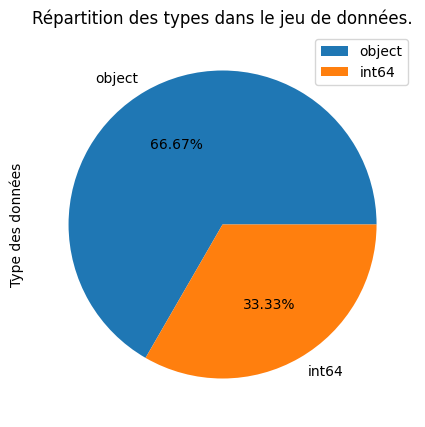


###### Les 5 premières et dernières lignes ######



,ids,date,user,text,flag,target
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NO_QUERY,0
1,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...,NO_QUERY,0
2,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...,NO_QUERY,0
3,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,NO_QUERY,0
4,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all....",NO_QUERY,0


,ids,date,user,text,flag,target
1599995,2193601966,Tue Jun 16 08:40:49 PDT 2009,AmandaMarie1028,Just woke up. Having no school is the best fee...,NO_QUERY,4
1599996,2193601969,Tue Jun 16 08:40:49 PDT 2009,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,NO_QUERY,4
1599997,2193601991,Tue Jun 16 08:40:49 PDT 2009,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,NO_QUERY,4
1599998,2193602064,Tue Jun 16 08:40:49 PDT 2009,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,NO_QUERY,4
1599999,2193602129,Tue Jun 16 08:40:50 PDT 2009,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...,NO_QUERY,4



###### Nombre de valeurs uniques ######



,ids,date,user,text,flag,target
0,1598315,774363,659775,1581466,1,2



###### Doublons génériques (toutes les variables sont utilisées) ######



0


###### Doublons sans l'index ######



188


###### Informations du taux de remplissage ######



Index(['ids', 'date', 'user', 'text', 'flag', 'target'], dtype='object')

array([100., 100., 100., 100., 100., 100.])

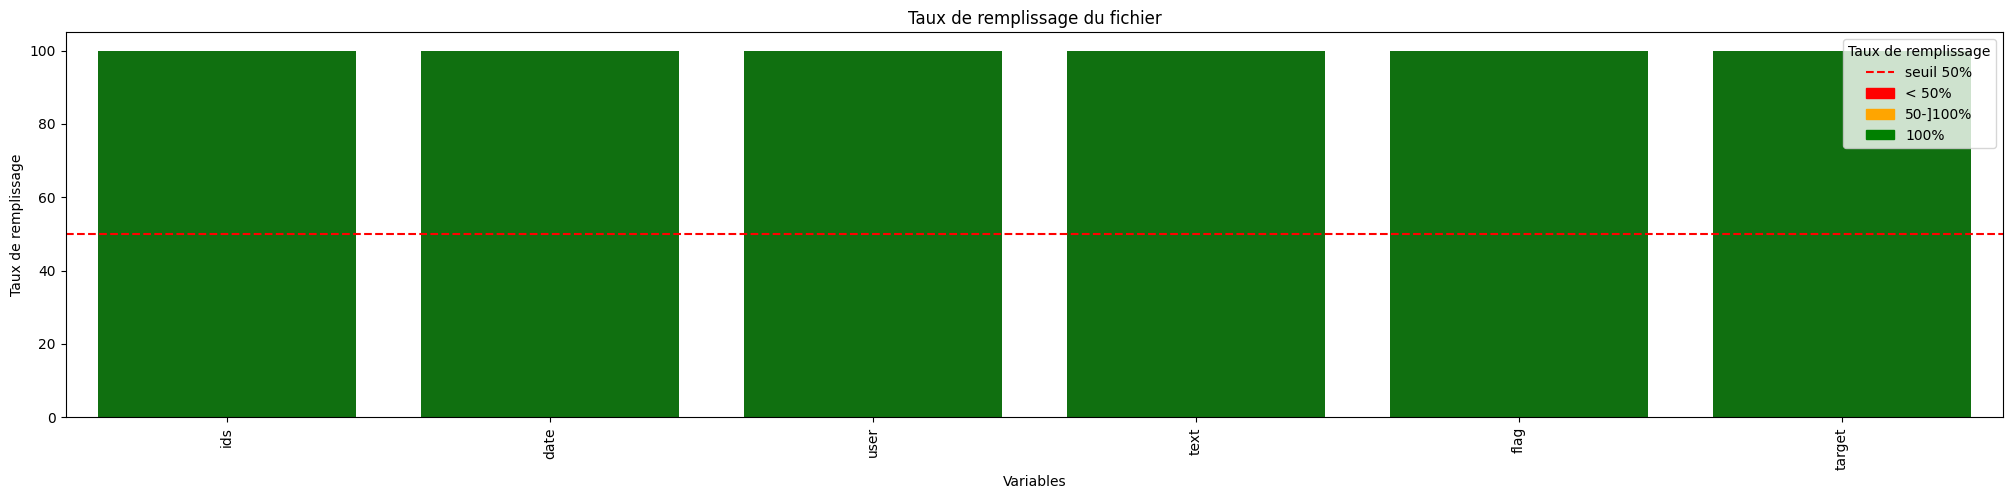

,Variable,% Taux remplissage



###### Statistiques descriptives ######



,ids,target
count,1.600000e+06,1.600000e+06
mean,1.998818e+09,2.000000e+00
std,1.935761e+08,2.000001e+00
min,1.467810e+09,0.000000e+00
25%,1.956916e+09,0.000000e+00
50%,2.002102e+09,2.000000e+00
75%,2.177059e+09,4.000000e+00
max,2.329206e+09,4.000000e+00



###### Boxplots des variables ######



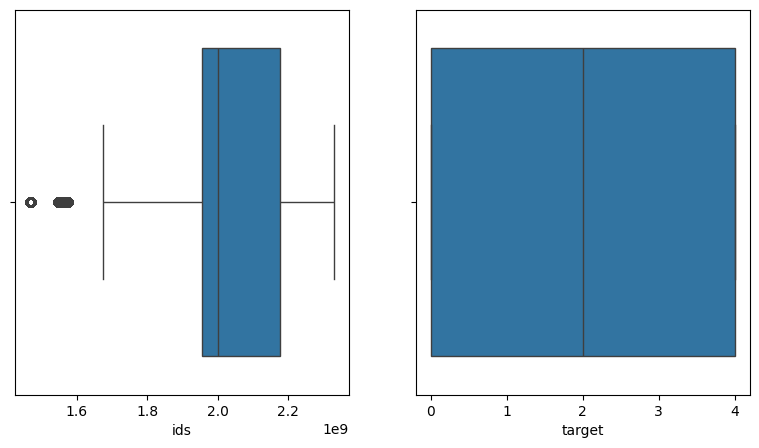

In [11]:
# Démarrer l'analyse exploratoire générique
analyse_exploratoire_generique(datas)

# 5 - Traitements simples

On définit les constantes des targets afin que ce soit uniforme dans tout le notebook

In [12]:
#définition de constantes
TARGET_NEGATIVE = 0
TARGET_POSITIVE = 4

Comme il n'y a qu'une seule valeur dans la variable flag, elle n'est pas utile, on la supprime

In [13]:
datas = datas.drop(columns="flag")

On définit la variable ids en tant qu'idex

In [14]:
datas = datas.set_index("ids")
datas = datas.sort_index()

On éliminte les tweets qui ont été dupliqués (erreur humaine ou technique)

In [15]:
datas_duplicated = datas[datas.duplicated(keep=False)]
datas_duplicated

,date,user,text,target
ids,,,,
1548613622,Fri Apr 17 21:27:11 PDT 2009,quietyourcackle,productive friday night i found an old song t...,4
1548613624,Fri Apr 17 21:27:11 PDT 2009,quietyourcackle,productive friday night i found an old song t...,4
1548614650,Fri Apr 17 21:27:22 PDT 2009,YaaaaZ,Why am I awake @ 8am on a Sat morning?? Whyyyy...,0
1548614652,Fri Apr 17 21:27:22 PDT 2009,YaaaaZ,Why am I awake @ 8am on a Sat morning?? Whyyyy...,0
1548797240,Fri Apr 17 22:00:01 PDT 2009,tweetpet,@tweetchild Clean Me!,0
...,...,...,...,...
2301988538,Tue Jun 23 16:11:03 PDT 2009,Susanluann,I effin locked my keys in my house and I'm stu...,0
2326023952,Thu Jun 25 06:26:14 PDT 2009,AlexandraG730,@Ashley_Cashen Yes! I have to see you before y...,0
2326023980,Thu Jun 25 06:26:14 PDT 2009,AlexandraG730,@Ashley_Cashen Yes! I have to see you before y...,0


In [16]:
# Reconstruire l'index
datas = datas.reset_index()
datas

,ids,date,user,text,target
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...,0
2,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...,0
3,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,0
4,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all....",0
...,...,...,...,...,...
1599995,2329205009,Thu Jun 25 10:28:28 PDT 2009,dandykim,Sick Spending my day laying in bed listening ...,0
1599996,2329205038,Thu Jun 25 10:28:28 PDT 2009,bigenya,Gmail is down?,0
1599997,2329205473,Thu Jun 25 10:28:30 PDT 2009,LeeLHoke,rest in peace Farrah! So sad,0
1599998,2329205574,Thu Jun 25 10:28:30 PDT 2009,davidlmulder,@Eric_Urbane Sounds like a rival is flagging y...,0


On vérifie que la variable target est bien équilibré

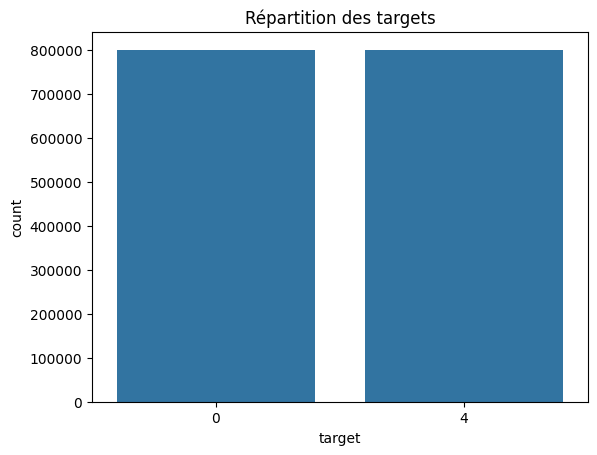

target
0    800000
4    800000
Name: count, dtype: int64

In [17]:
# Compter le nombre de la valeur utilisée pour la variable target
num_targets = datas["target"].value_counts()

# On l'affiche dans un diagramme en barre
sns.barplot(data=num_targets)
plt.title("Répartition des targets")
plt.show()

# On affiche les valeurs et leur nombre
num_targets

# 6 - Traitements lourds

In [18]:
# copier les données brutes
cdatas = datas.copy()

On effectue le prétraitement et la lemmatization de tout le contenu afin d'accélérer les futures utilisations.
C'est une tâche assez gourmande en ressource, par conséquent, cette tâche n'est utilisée qu'une seule fois, et on enregistre le résultat dans un fichier .csv qui sera utilisé à chaque fois.

In [19]:
# nom du fichier à enregistrer
result_file = "saved_preprocessed_lemming_datas.csv"

# SI le fichier n'existe pas, on lance le prétraitement
if not Path(result_file).exists():
    # Lemmatization
    lem_pdatas = datas.copy()
    lem_pdatas.loc[:, "text"] = datas["text"].apply(lambda x: preprocess_text(x, "lemming"))

    # Sauvegarde du résultat
    lem_pdatas.to_csv(result_file, index=False)
else:
    # Sinon on récupère le contenu du fichier enregistré
    lem_pdatas = pd.read_csv("saved_preprocessed_lemming_datas.csv")

Même chose en stemming

In [20]:
# nom du fichier à enregistrer
result_file = "saved_preprocessed_stemming_datas.csv"

# Si le fichier n'existe pas, on lance le prétraitement
if not Path(result_file).exists():
    # Stemming
    stem_pdatas = datas.copy()
    stem_pdatas.loc[:, "text"] = datas["text"].apply(lambda x: preprocess_text(x, "stemming"))

    # Sauvegarde du résultat
    stem_pdatas.to_csv(result_file, index=False)
else:
    # Sinon on récupère le contenu du fichier enregistré
    stem_pdatas = pd.read_csv("saved_preprocessed_stemming_datas.csv")

On vérifie la présence de valeur manquante, il se peut que la lemmatization ou le stemming ne parvient pas à transformer certains mots

In [21]:
print(cdatas["text"].isna().value_counts())
print(lem_pdatas["text"].isna().value_counts())
print(stem_pdatas["text"].isna().value_counts())

text
False    1600000
Name: count, dtype: int64
text
False    1599254
True         746
Name: count, dtype: int64
text
False    1599334
True         666
Name: count, dtype: int64


Comme ils sont très peu nombreux, on les supprime

In [22]:
cdatas = cdatas.dropna()
lem_pdatas = lem_pdatas.dropna()
stem_pdatas = stem_pdatas.dropna()

# 7 - Préparation des données

Les individus des fichiers sont en une quantité importante (1,6 millions), le temps de traitement nécessaire peut être assez conséquent, il est donc nécessaire de réduire le nombre d'échantillon afin qu'on puisse faire l'essentiel avant de passer à un échantillon plus important

In [23]:
# sélectionner les variables
cible_vars = ["text", "target"]

# construire un dataset réduit à 0,01% de l'échantillon d'origine afin d'accélérer les tests
brut_ldatas, brut_mdatas = train_test_split(cdatas[cible_vars], test_size=0.01, stratify=cdatas["target"], random_state=42) 
lem_ldatas, lem_mdatas = train_test_split(lem_pdatas[cible_vars], test_size=0.01, stratify=lem_pdatas["target"], random_state=42)
stem_ldatas, stem_mdatas = train_test_split(stem_pdatas[cible_vars], test_size=0.01, stratify=stem_pdatas["target"], random_state=42)

On modifie afin que les valeurs cibles soient binaires : 0 pour sentiment négatif et 1 pour sentiment positif

In [24]:
brut_mdatas.loc[brut_mdatas["target"] == 4, "target"] = 1
lem_mdatas.loc[lem_mdatas["target"] == 4, "target"] = 1
stem_mdatas.loc[stem_mdatas["target"] == 4, "target"] = 1

# 8 - Entraînement et tracking

## 8-1 - Normalisation lemmatization et stemming

In [25]:
lem_count_vectorizer = CountVectorizer()
lem_count_bow = lem_count_vectorizer.fit_transform(lem_mdatas["text"])

lem_tfidf_vectorizer = TfidfVectorizer()
lem_tfidf_bow = lem_tfidf_vectorizer.fit_transform(lem_mdatas["text"])

stem_count_vectorizer = CountVectorizer()
stem_count_bow = stem_count_vectorizer.fit_transform(stem_mdatas["text"])

stem_tfidf_vectorizer = TfidfVectorizer()
stem_tfidf_bow = stem_tfidf_vectorizer.fit_transform(stem_mdatas["text"])

## 8-2 - Sépéaration des échantillons en portions entraînement et portion test

In [26]:
brut_split_X_train, brut_split_X_test, brut_split_y_train, brut_split_y_test = train_test_split(brut_mdatas["text"], brut_mdatas["target"], random_state=42, test_size=0.3, stratify=brut_mdatas["target"])
split_brut_datas = {
    "X_train": brut_split_X_train,
    "X_test": brut_split_X_test,
    "y_train": brut_split_y_train,
    "y_test": brut_split_y_test
}

lem_split_X_train, lem_split_X_test, lem_split_y_train, lem_split_y_test = train_test_split(lem_mdatas["text"], lem_mdatas["target"], random_state=42, test_size=0.3, stratify=lem_mdatas["target"])
split_lem_datas = {
    "X_train": lem_split_X_train,
    "X_test": lem_split_X_test,
    "y_train": lem_split_y_train,
    "y_test": lem_split_y_test
}

stem_split_X_train, stem_split_X_test, stem_split_y_train, stem_split_y_test = train_test_split(stem_mdatas["text"], stem_mdatas["target"], random_state=42, test_size=0.3, stratify=stem_mdatas["target"])
split_stem_datas = {
    "X_train": stem_split_X_train,
    "X_test": stem_split_X_test,
    "y_train": stem_split_y_train,
    "y_test": stem_split_y_test
}

lem_count_X_train, lem_count_X_test, lem_count_y_train, lem_count_y_test = train_test_split(lem_count_bow, lem_mdatas["target"], random_state=42, test_size=0.3, stratify=lem_mdatas["target"])
lem_count_datas = {
    "X_train": lem_count_X_train,
    "X_test": lem_count_X_test,
    "y_train": lem_count_y_train,
    "y_test": lem_count_y_test
}

lem_tfidf_X_train, lem_tfidf_X_test, lem_tfidf_y_train, lem_tfidf_y_test = train_test_split(lem_tfidf_bow, lem_mdatas["target"], random_state=42, test_size=0.3, stratify=lem_mdatas["target"])
lem_tfidf_datas = {
    "X_train": lem_tfidf_X_train,
    "X_test": lem_tfidf_X_test,
    "y_train": lem_tfidf_y_train,
    "y_test": lem_tfidf_y_test
}

stem_count_X_train, stem_count_X_test, stem_count_y_train, stem_count_y_test = train_test_split(stem_count_bow, stem_mdatas["target"], random_state=42, test_size=0.3, stratify=stem_mdatas["target"])
stem_count_datas = {
    "X_train": stem_count_X_train,
    "X_test": stem_count_X_test,
    "y_train": stem_count_y_train,
    "y_test": stem_count_y_test
}

stem_tfidf_X_train, stem_tfidf_X_test, stem_tfidf_y_train, stem_tfidf_y_test = train_test_split(stem_tfidf_bow, stem_mdatas["target"], random_state=42, test_size=0.3, stratify=stem_mdatas["target"])
stem_tfidf_datas = {
    "X_train": stem_tfidf_X_train,
    "X_test": stem_tfidf_X_test,
    "y_train": stem_tfidf_y_train,
    "y_test": stem_tfidf_y_test
}

## 8-3 Lancement des entraînement et le tracking

### 8-3-1 - Modèles simples (avec Bag of words)

#### 8-3-1-1 - LogisticRegression

In [27]:
params = {
    "C": [0.1, 1, 10],
    "max_iter": [100, 150]
}

model = LogisticRegression()

run_name="Logistic Regression Lem SimpleCount"
track_model_training(model, lem_count_datas, params, "sklearn", run_name, lem_count_vectorizer)

run_name="Logistic Regression Lem TDIDF"
track_model_training(model, lem_tfidf_datas, params, "sklearn", run_name, lem_tfidf_vectorizer)

run_name="Logistic Regression Stem SimpleCount"
track_model_training(model, stem_count_datas, params, "sklearn", run_name, stem_count_vectorizer)

run_name="Logistic Regression Stem TDIDF"
track_model_training(model, stem_tfidf_datas, params, "sklearn", run_name, stem_tfidf_vectorizer)

#### 8-3-1-2 - RandomForestClassifier()

In [28]:
model = RandomForestClassifier()
params = {
    "n_estimators": [50, 100],
    "max_depth": [100, None],
    "min_samples_split": [2, 3],
    "random_state": [42],
}

run_name="Random Forest Lem SimpleCount"
track_model_training(model, lem_count_datas, params, "sklearn", run_name, lem_count_vectorizer)

run_name="Random Forest Lem TDIDF"
track_model_training(model, lem_tfidf_datas, params, "sklearn", run_name, lem_tfidf_vectorizer)

run_name="Random Forest Stem SimpleCount"
track_model_training(model, stem_count_datas, params, "sklearn", run_name, stem_count_vectorizer)

run_name="Random Forest Stem TDIDF"
track_model_training(model, stem_tfidf_datas, params, "sklearn", run_name, stem_tfidf_vectorizer)

#### 8-3-1-3 - GradientBoostingClassifier

In [29]:
model = GradientBoostingClassifier()
params = {
    "n_estimators": [50, 100],
    "learning_rate": [0.1, 0.5],
    "max_depth": [3, 10],
    "random_state": [42],
}

run_name="Gradient Boosting Lem SimpleCount"
track_model_training(model, lem_count_datas, params, "sklearn", run_name, lem_count_vectorizer)

run_name="Gradient Boosting Lem TDIDF"
track_model_training(model, lem_count_datas, params, "sklearn", run_name, lem_tfidf_vectorizer)

run_name="Gradient Boosting Stem SimpleCount"
track_model_training(model, stem_count_datas, params, "sklearn", run_name, stem_count_vectorizer)

run_name="Gradient Boosting Stem TDIDF"
track_model_training(model, stem_count_datas, params, "sklearn", run_name, stem_tfidf_vectorizer)

### 8-3-2 - Modèles avancés (avec word embedding)

#### 8-3-2-1 - Word2VecTransformer

In [30]:
# Pipeline
pipeline = Pipeline([
    ("word2vec", Word2VecTransformer()),
    ("logisticRegression", LogisticRegression())
])

# Paramètres à tester
params = {
    "word2vec__vector_size": [100, 200],
    "word2vec__window": [5, 10],
    "logisticRegression__C": [0.1, 1, 10],
    "logisticRegression__max_iter": [100, 150]
}


run_name="Word2Vec -> Logistic Regression Lem"
track_model_training(pipeline, split_lem_datas, params, "sklearn", run_name)

run_name="Word2Vec -> Logistic Regression Stem"
track_model_training(pipeline, split_stem_datas, params, "sklearn", run_name)

In [31]:
# Pipeline
pipeline = Pipeline([
    ("word2vec", Word2VecTransformer()),
    ("randomForestClassifier", RandomForestClassifier())
])

# Paramètres à tester
params = {
    "word2vec__vector_size": [100, 200],
    "word2vec__window": [5, 10],
    "randomForestClassifier__n_estimators": [50, 100],
    "randomForestClassifier__max_depth": [100, None],
    "randomForestClassifier__min_samples_split": [2, 3],
    "randomForestClassifier__random_state": [42],
}

run_name="Word2Vec -> Random Forest Lem"
track_model_training(pipeline, split_lem_datas, params, "sklearn", run_name)

run_name="Word2Vec -> Random Forest Stem"
track_model_training(pipeline, split_stem_datas, params, "sklearn", run_name)

#### 8-3-2-3 - FastTextTransformer

In [32]:
# Pipeline
pipeline = Pipeline([
    ("fastText", FastTextTransformer()),
    ("logisticRegression", LogisticRegression())
])

# Paramètres à tester
params = {
    "fastText__vector_size": [50, 100],
    "fastText__window": [2, 5],
    "logisticRegression__C": [0.1, 1, 2],
    "logisticRegression__max_iter": [50, 100]
}


run_name="FastText -> Logistic Regression Lem"
track_model_training(pipeline, split_lem_datas, params, "sklearn", run_name)

run_name="FastText -> Logistic Regression Stem"
track_model_training(pipeline, split_stem_datas, params, "sklearn", run_name)

#### 8-3-2-4 - BertForSequenceClassification

In [34]:
# Paramètres à tester
params = {"model_name": "nlptown/bert-base-multilingual-uncased-sentiment",
          "learning_rates": [1e-5, 5e-5],
          "batch_sizes": [64],
          "num_epochs": 1 
        }

run_name="Fine Tuning Bert"
track_model_training(BertTransformer, split_brut_datas, params, "fine_tuning_bert", run_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/117 [00:00<?, ?it/s]

c:\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 0.6131, 'grad_norm': 4.2013840675354, 'learning_rate': 9.145299145299145e-06, 'epoch': 0.09}
{'loss': 0.54, 'grad_norm': 4.864316940307617, 'learning_rate': 8.290598290598293e-06, 'epoch': 0.17}
{'loss': 0.5051, 'grad_norm': 4.872834205627441, 'learning_rate': 7.435897435897437e-06, 'epoch': 0.26}
{'loss': 0.4977, 'grad_norm': 6.5820794105529785, 'learning_rate': 6.581196581196582e-06, 'epoch': 0.34}
{'loss': 0.5456, 'grad_norm': 8.897537231445312, 'learning_rate': 5.726495726495727e-06, 'epoch': 0.43}
{'loss': 0.4927, 'grad_norm': 3.3178956508636475, 'learning_rate': 4.871794871794872e-06, 'epoch': 0.51}
{'loss': 0.5157, 'grad_norm': 3.6120615005493164, 'learning_rate': 4.017094017094018e-06, 'epoch': 0.6}
{'loss': 0.5016, 'grad_norm': 3.285465955734253, 'learning_rate': 3.1623931623931626e-06, 'epoch': 0.68}
{'loss': 0.4925, 'grad_norm': 4.423178672790527, 'learning_rate': 2.307692307692308e-06, 'epoch': 0.77}
{'loss': 0.4857, 'grad_norm': 3.6942405700683594, 'learning_rate'

  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.4808505177497864, 'eval_accuracy': 0.775307980717729, 'eval_runtime': 5.5118, 'eval_samples_per_second': 677.454, 'eval_steps_per_second': 10.704, 'epoch': 1.0}
{'train_runtime': 44.1465, 'train_samples_per_second': 169.119, 'train_steps_per_second': 2.65, 'train_loss': 0.5148598842131786, 'epoch': 1.0}


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

{'loss': 0.4845, 'grad_norm': 5.027162551879883, 'learning_rate': 9.145299145299145e-06, 'epoch': 0.09}
{'loss': 0.455, 'grad_norm': 5.404497146606445, 'learning_rate': 8.290598290598293e-06, 'epoch': 0.17}
{'loss': 0.4734, 'grad_norm': 5.625996112823486, 'learning_rate': 7.435897435897437e-06, 'epoch': 0.26}
{'loss': 0.481, 'grad_norm': 4.360198020935059, 'learning_rate': 6.581196581196582e-06, 'epoch': 0.34}
{'loss': 0.4608, 'grad_norm': 4.0100579261779785, 'learning_rate': 5.726495726495727e-06, 'epoch': 0.43}
{'loss': 0.4158, 'grad_norm': 5.01616907119751, 'learning_rate': 4.871794871794872e-06, 'epoch': 0.51}
{'loss': 0.4632, 'grad_norm': 3.8940436840057373, 'learning_rate': 4.017094017094018e-06, 'epoch': 0.6}
{'loss': 0.4601, 'grad_norm': 4.35846471786499, 'learning_rate': 3.1623931623931626e-06, 'epoch': 0.68}
{'loss': 0.499, 'grad_norm': 4.548609256744385, 'learning_rate': 2.307692307692308e-06, 'epoch': 0.77}
{'loss': 0.4386, 'grad_norm': 3.141974687576294, 'learning_rate': 1

  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.4175534248352051, 'eval_accuracy': 0.8084650415215644, 'eval_runtime': 5.3692, 'eval_samples_per_second': 695.261, 'eval_steps_per_second': 10.989, 'epoch': 1.0}
{'train_runtime': 43.3412, 'train_samples_per_second': 172.284, 'train_steps_per_second': 2.7, 'train_loss': 0.4563002015790369, 'epoch': 1.0}


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

{'loss': 0.4601, 'grad_norm': 3.9106392860412598, 'learning_rate': 9.145299145299145e-06, 'epoch': 0.09}
{'loss': 0.3951, 'grad_norm': 4.298120975494385, 'learning_rate': 8.290598290598293e-06, 'epoch': 0.17}
{'loss': 0.4337, 'grad_norm': 4.426464080810547, 'learning_rate': 7.435897435897437e-06, 'epoch': 0.26}
{'loss': 0.4958, 'grad_norm': 4.00469446182251, 'learning_rate': 6.581196581196582e-06, 'epoch': 0.34}
{'loss': 0.4356, 'grad_norm': 5.4071245193481445, 'learning_rate': 5.726495726495727e-06, 'epoch': 0.43}
{'loss': 0.4282, 'grad_norm': 3.147089719772339, 'learning_rate': 4.871794871794872e-06, 'epoch': 0.51}
{'loss': 0.4458, 'grad_norm': 4.512417316436768, 'learning_rate': 4.017094017094018e-06, 'epoch': 0.6}
{'loss': 0.4131, 'grad_norm': 7.013838291168213, 'learning_rate': 3.1623931623931626e-06, 'epoch': 0.68}
{'loss': 0.4467, 'grad_norm': 5.983631610870361, 'learning_rate': 2.307692307692308e-06, 'epoch': 0.77}
{'loss': 0.4042, 'grad_norm': 4.350086688995361, 'learning_rate

  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.36300602555274963, 'eval_accuracy': 0.8483793195821056, 'eval_runtime': 5.6403, 'eval_samples_per_second': 661.848, 'eval_steps_per_second': 10.46, 'epoch': 1.0}
{'train_runtime': 44.2423, 'train_samples_per_second': 168.775, 'train_steps_per_second': 2.645, 'train_loss': 0.4318717932089781, 'epoch': 1.0}


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

{'loss': 0.344, 'grad_norm': 3.8658666610717773, 'learning_rate': 4.572649572649573e-05, 'epoch': 0.09}
{'loss': 0.3457, 'grad_norm': 5.942599296569824, 'learning_rate': 4.145299145299146e-05, 'epoch': 0.17}
{'loss': 0.366, 'grad_norm': 6.948451995849609, 'learning_rate': 3.717948717948718e-05, 'epoch': 0.26}
{'loss': 0.387, 'grad_norm': 7.06454610824585, 'learning_rate': 3.290598290598291e-05, 'epoch': 0.34}
{'loss': 0.4425, 'grad_norm': 4.605499744415283, 'learning_rate': 2.863247863247863e-05, 'epoch': 0.43}
{'loss': 0.3882, 'grad_norm': 6.7678141593933105, 'learning_rate': 2.435897435897436e-05, 'epoch': 0.51}
{'loss': 0.4371, 'grad_norm': 4.30519962310791, 'learning_rate': 2.0085470085470087e-05, 'epoch': 0.6}
{'loss': 0.4226, 'grad_norm': 4.878062725067139, 'learning_rate': 1.581196581196581e-05, 'epoch': 0.68}
{'loss': 0.4082, 'grad_norm': 5.265462875366211, 'learning_rate': 1.153846153846154e-05, 'epoch': 0.77}
{'loss': 0.4114, 'grad_norm': 3.8538315296173096, 'learning_rate': 

  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.3937140703201294, 'eval_accuracy': 0.8283342260310659, 'eval_runtime': 5.327, 'eval_samples_per_second': 700.955, 'eval_steps_per_second': 11.076, 'epoch': 1.0}
{'train_runtime': 44.6648, 'train_samples_per_second': 167.156, 'train_steps_per_second': 2.62, 'train_loss': 0.40324022015954697, 'epoch': 1.0}


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

{'loss': 0.3246, 'grad_norm': 15.84599781036377, 'learning_rate': 4.572649572649573e-05, 'epoch': 0.09}
{'loss': 0.3456, 'grad_norm': 5.808497905731201, 'learning_rate': 4.145299145299146e-05, 'epoch': 0.17}
{'loss': 0.3772, 'grad_norm': 7.807981014251709, 'learning_rate': 3.717948717948718e-05, 'epoch': 0.26}
{'loss': 0.3896, 'grad_norm': 9.536588668823242, 'learning_rate': 3.290598290598291e-05, 'epoch': 0.34}
{'loss': 0.3502, 'grad_norm': 5.550105571746826, 'learning_rate': 2.863247863247863e-05, 'epoch': 0.43}
{'loss': 0.3083, 'grad_norm': 6.038416385650635, 'learning_rate': 2.435897435897436e-05, 'epoch': 0.51}
{'loss': 0.3522, 'grad_norm': 7.605138778686523, 'learning_rate': 2.0085470085470087e-05, 'epoch': 0.6}
{'loss': 0.3807, 'grad_norm': 6.999648094177246, 'learning_rate': 1.581196581196581e-05, 'epoch': 0.68}
{'loss': 0.4359, 'grad_norm': 5.13873815536499, 'learning_rate': 1.153846153846154e-05, 'epoch': 0.77}
{'loss': 0.3967, 'grad_norm': 4.529337406158447, 'learning_rate':

  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.30749717354774475, 'eval_accuracy': 0.8762389499062416, 'eval_runtime': 5.3845, 'eval_samples_per_second': 693.287, 'eval_steps_per_second': 10.957, 'epoch': 1.0}
{'train_runtime': 43.0559, 'train_samples_per_second': 173.426, 'train_steps_per_second': 2.717, 'train_loss': 0.3667229648329254, 'epoch': 1.0}


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

{'loss': 0.3031, 'grad_norm': 5.160166263580322, 'learning_rate': 4.572649572649573e-05, 'epoch': 0.09}
{'loss': 0.2595, 'grad_norm': 7.809370994567871, 'learning_rate': 4.145299145299146e-05, 'epoch': 0.17}
{'loss': 0.335, 'grad_norm': 5.361300468444824, 'learning_rate': 3.717948717948718e-05, 'epoch': 0.26}
{'loss': 0.3675, 'grad_norm': 5.567443370819092, 'learning_rate': 3.290598290598291e-05, 'epoch': 0.34}
{'loss': 0.3056, 'grad_norm': 4.339099407196045, 'learning_rate': 2.863247863247863e-05, 'epoch': 0.43}
{'loss': 0.3296, 'grad_norm': 7.752760887145996, 'learning_rate': 2.435897435897436e-05, 'epoch': 0.51}
{'loss': 0.3454, 'grad_norm': 9.614545822143555, 'learning_rate': 2.0085470085470087e-05, 'epoch': 0.6}
{'loss': 0.3248, 'grad_norm': 8.783266067504883, 'learning_rate': 1.581196581196581e-05, 'epoch': 0.68}
{'loss': 0.3515, 'grad_norm': 7.46834135055542, 'learning_rate': 1.153846153846154e-05, 'epoch': 0.77}
{'loss': 0.3126, 'grad_norm': 6.667002201080322, 'learning_rate': 

  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.226349875330925, 'eval_accuracy': 0.9174926332708278, 'eval_runtime': 5.8111, 'eval_samples_per_second': 642.393, 'eval_steps_per_second': 10.153, 'epoch': 1.0}
{'train_runtime': 44.6888, 'train_samples_per_second': 167.089, 'train_steps_per_second': 2.618, 'train_loss': 0.3230963221981994, 'epoch': 1.0}


  0%|          | 0/59 [00:00<?, ?it/s]

2024/10/22 00:48:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run intelligent-gnat-906 at: http://127.0.0.1:8080/#/experiments/778457007112658367/runs/62078c9e147747359b958f0b08cfa6d5.
2024/10/22 00:48:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/778457007112658367.
2024/10/22 00:48:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run thoughtful-dog-776 at: http://127.0.0.1:8080/#/experiments/778457007112658367/runs/6e05fbc1840b4cfd93e80cec30ac5452.
2024/10/22 00:48:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/778457007112658367.
2024/10/22 00:48:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fine Tuning Bert at: http://127.0.0.1:8080/#/experiments/778457007112658367/runs/8be2c943ce074c63a18f3e6b5667d0a9.
2024/10/22 00:48:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/